# 가위바위보 판별기 복습 및 정리

- 07/28 수행, Exploration 1
- 기존의 학습 데이터, 평가데이터로 모델 구현, 학습, 평가
- 새로운 학습 데이터, 평가 데이터로 학습, 평가

## 1. 모듈 import

In [13]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import layers

## 2. 데이터 만들기

- [직접 데이터셋을 만들어 본다](https://teachablemachine.withgoogle.com/)
- 위 링크로 들어가서 ```Get Started```, ```Image Project```로 들어가서 웹캠으로 가위, 바위, 보에 대한 사진을 100장정도씩 찍어서 준비한다
- 찍고나서 ```Download Samples```로 퐐영한 데이터를 다운 받는다.
![image](https://user-images.githubusercontent.com/48716219/89101974-e8ae8100-d43f-11ea-8896-77eefbf6c774.png)
- 저장경로는 '~/aiffel/rock_scissor_paper/' 위치에 각각 rock, scissor, paper의 디렉토리를 생성하고 

### 2_1. 압축해제

In [14]:
from zipfile import ZipFile as ZF

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/"

# 압축해제
zip_paths = glob(image_dir_path + '*.zip')
for zip_path in zip_paths :
    # 경로에서 클래스명 따로 추출 (rock, scissors, paper)
    class_name = zip_path.split('/')[-1].split('-')[0]
    with ZF(zip_path) as zf:
        zf.extractall(image_dir_path+class_name)
        zf.close()
    

### 2_2. image resize
다운받은 데이터셋의 사이즈를 확인해보았다.  

1. 각 이미지들을 PIL를 사용해서 연다
2. 그 이미지들을 numpy array로 변환
3. ```shape```를 확인해서 ```height```, ```width```, ```channel```값을 리스트에 저장
4. ```np.unique```를 사용해서 전체 데이터셋이 어떠한 값으로 이루어져 있는지 확인한다.  
5. 이미지를 ```matplotlib```을 활용해서 직접 확인해본다.

전체 이미지 수 : 100장
h:[224], w:[224], c:[3]


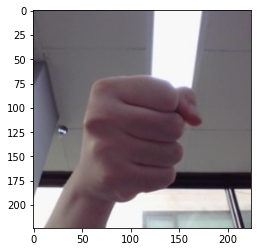

In [15]:
# 먼저 다운받은 image인
image_paths = glob(image_dir_path+'rock/*.jpg')
images = []
hs, ws, cs = [], [], []
for image_path in image_paths:
    pil_image = Image.open(image_path)
    np_image = np.array(pil_image)
    h, w, c = np_image.shape
    hs.append(h)
    ws.append(w)
    cs.append(c)
    images.append(np_image)
    
print("전체 이미지 수 : {}장".format(len(images)))
print("h:{}, w:{}, c:{}".format(np.unique(hs), np.unique(ws), np.unique(cs)))

plt.imshow(images[0])
plt.show()

6. image를 8x8 사이즈로 resize해준다.
 - 이미지들의 경로 불러오기, ```target_size```로 resize
 - 기존의 경로에 resize한 데이터 다시 저장
 - ```tqdm``` : 진행도를 보기 좋다

In [16]:
target_size = (28, 28)
classes = ['rock', 'scissors', 'paper']

for cls in classes:
    
    target_path = image_dir_path + cls
    image_paths = glob(target_path + '/*.jpg')
    
    for image_path in tqdm(image_paths) :
        old_img = Image.open(image_path)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(image_path,"JPEG")
    
    print("{}, resize 완료".format(cls))


rock, resize 완료



scissors, resize 완료



paper, resize 완료


## 3. Data Load
- input : 이미지 경로 / output : numpy array로 열린 이미지가 모두 담긴 리스트, 각 이미지에 대한 라벨이 담긴 리스트
- 기존의 함수를 조금 변형을 해보았다
 - 경로를 한꺼번에 다 읽어오고, 경로에 명시되어 있는 class들의 이름으로 새롭게 label데이터를 생성
- 기존의 함수  

 ```python
 def load_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    number_of_data=300   # 가위바위보 이미지 개수 총합에 주의하세요.
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는",idx,"입니다.")
    return imgs, labels
```

In [17]:
def load_data(path):
    # 경로를 다 읽어 온다.
    total_image_paths = glob(path + '*/*.jpg')
    number_of_data = len(total_image_paths)
    img_size = 28 # 이전에 resize 해준 사진의 size
    color = 3 # RGB의 3채널
    
    # 데이터, 라벨을 담을 공간을 미리 만든다
    imgs = np.zeros(number_of_data*img_size*img_size*color, dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels = np.zeros(number_of_data,dtype=np.int32)
    
    idx = 0
    for image in total_image_paths:
        
        # 경로에서 이미지의 라벨을 추출
        img_label = image.split('/')[-2]
        if img_label == "scissors":
            label = 0
        elif img_label == "rock":
            label = 1
        elif img_label == "paper":
            label = 2
        else :
            print("wrong class")
            return None
        
        img = np.array(Image.open(image), dtype=np.int32)
        imgs[idx,:,:,:] = img   # 데이터 영역에 이미지 행렬 복사
        labels[idx] = label     # 추출한 라벨값 복사
        
        idx+=1
    
    print("학습데이터(x_train)의 이미지 개수는",idx,"입니다.")
    return imgs, labels

In [18]:
(x_data, y_label)=load_data(image_dir_path)
x_data_norm = x_data/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_data_norm shape: {}".format(x_data_norm.shape))
print("y_label shape: {}".format(y_label.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_data_norm shape: (300, 28, 28, 3)
y_label shape: (300,)


## +. validation dataset 나누기
- 위에서 load한 데이터들을 8:2의 비율로 validation dataset을 만들어 준다.

In [19]:
# 이미지와 라벨에 대한 길이는 같다.
data_len = len(x_data)

x_train, x_valid = x_data_norm[:int(data_len*0.8)], x_data_norm[int(data_len*0.8):]
y_train, y_valid = y_label[:int(data_len*0.8)], y_label[int(data_len*0.8):]

print("x_train: {}, x_valid: {}".format(len(x_train), len(x_valid)))
print("y_train: {}, y_valid: {}".format(len(y_train), len(y_valid)))

x_train: 240, x_valid: 60
y_train: 240, y_valid: 60


### 처리한 데이터 확인 

라벨: 2


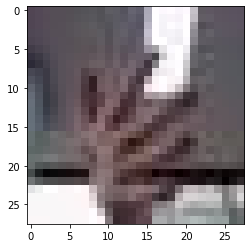

In [20]:
plt.imshow(x_train[0])
print('라벨:', y_train[0])

## 4. model 설계

In [21]:
inputs = layers.Input((28, 28, 3), name = 'input_layer')

# Feature Extraction
net = layers.Conv2D(32, (3, 3), padding = 'SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D((2,2))(net)
net = layers.Dropout(0.3)(net)

net = layers.Conv2D(64, (3, 3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D((2,2))(net)
net = layers.Dropout(0.3)(net)

# Classification
net = layers.Flatten()(net)
net = layers.Dense(128)(net)
net = layers.Activation('relu')(net)
net = layers.Dense(3)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='simple_cnn')

model.summary()

Model: "simple_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 64)        0

## 5. model 학습

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=30)

Epoch 1/30
8/8 [==============================] - 0s 12ms/step - loss: 1.0856 - accuracy: 0.3958 - val_loss: 1.3356 - val_accuracy: 0.0000e+00
Epoch 2/30
8/8 [==============================] - 0s 4ms/step - loss: 1.0255 - accuracy: 0.5250 - val_loss: 1.2703 - val_accuracy: 0.0000e+00
Epoch 3/30
8/8 [==============================] - 0s 3ms/step - loss: 0.9478 - accuracy: 0.6583 - val_loss: 1.5851 - val_accuracy: 0.0000e+00
Epoch 4/30
8/8 [==============================] - 0s 3ms/step - loss: 0.8951 - accuracy: 0.6792 - val_loss: 1.4477 - val_accuracy: 0.0000e+00
Epoch 5/30
8/8 [==============================] - 0s 4ms/step - loss: 0.8285 - accuracy: 0.6833 - val_loss: 1.2936 - val_accuracy: 0.0000e+00
Epoch 6/30
8/8 [==============================] - 0s 3ms/step - loss: 0.7407 - accuracy: 0.6833 - val_loss: 1.4417 - val_accuracy: 0.0000e+00
Epoch 7/30
8/8 [==============================] - 0s 3ms/step - loss: 0.7182 - accuracy: 0.7125 - val_loss: 1.0319 - val_accuracy: 0.2000
Epoch 8/3

In [23]:
model.save('/home/aiffel0042/Documents/aiffel_project/ainize/models/saved_model.pb')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /home/aiffel0042/Documents/aiffel_project/ainize/models/saved_model.pb/assets


### +. 그래프 시각화
- epoch이 적어서 그래프가 너무 이상하게 나온다
- 하지만 ```loss```값이 줄면서 ```accuracy```가 오르는 것은 확인할 수 있다.

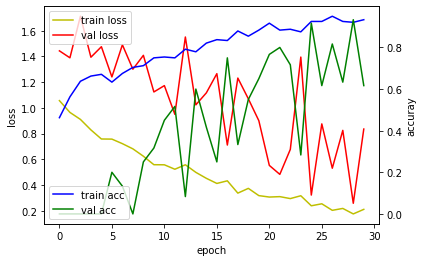

In [11]:
%matplotlib inline

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 6. model 평가
- 학습데이터에 포함이 되지 않는 새로운 데이터들을 사용해서 평가를 한다.

In [12]:
if os.path.exists('Downloads/test_rcp/'):
    test_path = 'Downloads/test_rcp/'

In [13]:
(x_test, y_test) = load_data(test_path)
x_test = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [14]:
model.evaluate(x_test, y_test)

10/10 [==============================] - 2s 151ms/step - loss: 1.4959 - accuracy: 0.3900


[1.495943546295166, 0.38999998569488525]

### 처참한 결과가 나왔다.
예측을 제대로 수행하지 못한다.  
그 이유를 아무래도 데이터에서 찾아보았다.  
1. 배경정보
 - 테스트 데이터에 대해서 다른분께 받아서 평가를 했다.
 - 내가 만든 데이터셋의 경우 위에 전등과 천장, 그 밑으로는 창문에 있었다.
 - 다른분께 받은 데이터에는 얼굴에 포함되어 있었고 뒤에는 창문이 있었다.
2. 데이터의 부족
 - 학습시키는 데이터가 300장 뿐이라서 학습이 제대로 수행되지 않았을 것이다.

이러한 결과를 통해서 28x28의 작은 사진을 학습시키는 것이지만 생각보다 결과가 좋지 않게 나온 것을 봐서 아무래도 데이터의 **양**과 **질**이 얼마나 중요한지 알 수 있었다.

## 7. 새로운 학습 데이터와 평가 데이터
- 수업이 끝난 후, 다른 분께서 올려주신 학습 데이터와 평가 데이터로 진행해보았다.

### 7_1. 저장된 데이터 불러오기
- numpy로 저장되어 있는 데이터를 불러오고 ```shape```와 사진을 시각화해서 확인해보았다.

x_train: (8961, 28, 28, 3), y_train: (8961,)
x_test: (3916, 28, 28, 3), y_test: (3916,)


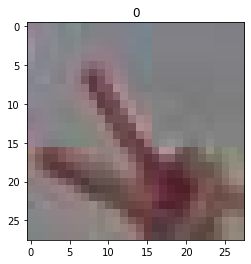

In [15]:
x_train = np.load('./Documents/aiffel_project/rock_scissors_paper/data/x_train.npy')
y_train = np.load('./Documents/aiffel_project/rock_scissors_paper/data/y_train.npy')
x_test = np.load('./Documents/aiffel_project/rock_scissors_paper/data/x_test.npy')
y_test = np.load('./Documents/aiffel_project/rock_scissors_paper/data/y_test.npy')

# 데이터확인
print("x_train: {}, y_train: {}".format(x_train.shape, y_train.shape))
print("x_test: {}, y_test: {}".format(x_test.shape, y_test.shape))

# 이미지 확인
plt.imshow(x_train[1,:,:,:])
plt.title(y_train[1])
plt.show()

### 7_2. model 만들기
- 위에서 만든 모델을 그대로 가져왔다.

In [16]:
inputs = layers.Input((28, 28, 3), name = 'input_layer')

# Feature Extraction
net = layers.Conv2D(32, (3, 3), padding = 'SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D((2,2))(net)
net = layers.Dropout(0.3)(net)

net = layers.Conv2D(64, (3, 3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D((2,2))(net)
net = layers.Dropout(0.3)(net)

# Classification
net = layers.Flatten()(net)
net = layers.Dense(128)(net)
net = layers.Activation('relu')(net)
net = layers.Dense(3)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='simple_cnn')

model.summary()

Model: "simple_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 64)        0

### 7_3. 학습
- 위에서 사용한 learning_rate도 그대로 적용

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(x_train, y_train, epochs=30)

Epoch 1/30
281/281 [==============================] - 4s 13ms/step - loss: 1.0109 - accuracy: 0.4671
Epoch 2/30
281/281 [==============================] - 0s 1ms/step - loss: 0.7334 - accuracy: 0.6772
Epoch 3/30
281/281 [==============================] - 0s 2ms/step - loss: 0.5742 - accuracy: 0.7576
Epoch 4/30
281/281 [==============================] - 0s 2ms/step - loss: 0.4636 - accuracy: 0.8123
Epoch 5/30
281/281 [==============================] - 0s 1ms/step - loss: 0.4159 - accuracy: 0.8346
Epoch 6/30
281/281 [==============================] - 0s 1ms/step - loss: 0.3183 - accuracy: 0.8806
Epoch 7/30
281/281 [==============================] - 0s 2ms/step - loss: 0.2676 - accuracy: 0.9016
Epoch 8/30
281/281 [==============================] - 0s 1ms/step - loss: 0.2199 - accuracy: 0.9207
Epoch 9/30
281/281 [==============================] - 0s 1ms/step - loss: 0.1931 - accuracy: 0.9306
Epoch 10/30
281/281 [==============================] - 0s 1ms/step - loss: 0.1591 - accuracy: 0.946

### 7_4. 그래프 시각화
- 아까보다 훨씬 매끄러운 곡선이 나왔다.
- validation dataset은 만들지 않아서 ```test```에 대한 ```loss```와 ```acc```만 확인하였다.

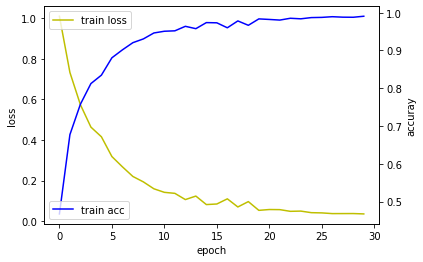

In [18]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### 7_5. 평가
- 엄청난 점수가 나왔다. 모델은 문제가 없었다.
- 데이터가 문제였다.
- 생각해보면 dataset을 처음에 만들때 손을 세워서 찍은 사진이 쫌 많이 있었다. 아무래도 그것도 너무 어려운 사진이지 않았나 싶다.

In [19]:
model.evaluate(x_test, y_test)

123/123 [==============================] - 0s 949us/step - loss: 0.8603 - accuracy: 0.8044


[0.8602527976036072, 0.8043922185897827]

### 7_6. 평가 시각화
- 평가 데이터 중 일부를 랜덤하게 뽑아서 사진과 라벨에 대한 값을 확인해보자

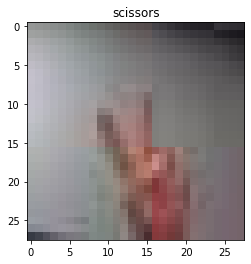

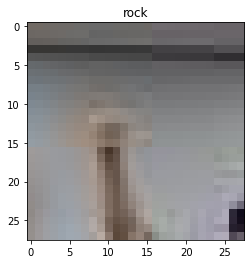

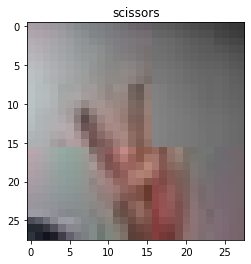

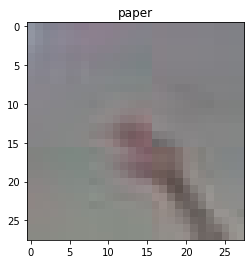

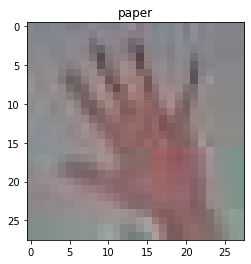

In [20]:
for i in range(5):
    rand_img = x_test[np.random.randint(len(x_test))]
    # 차원 추가, 예측
    pred_img = rand_img[np.newaxis, :, :, :]
    pred = model.predict(pred_img)
    
    # 이미지 확인
    plt.imshow(rand_img)
    
    if np.argmax(pred[0]) == 0 :
        predict = "scissors"
    elif np.argmax(pred[0]) == 1 :
        predict = "rock"
    else :
        predict = "paper"
    plt.title(predict)
    plt.show()